In [12]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Tensorflow
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.optimizers import Adam



In [13]:
# Paths
train_dir = './train'
test_dir = './test'

# Hyperparameters
CFG = dict(
    seed = 77,
    batch_size = 16,
    img_size = (299,299),
    epochs = 5,
    patience = 5
)

In [ ]:
train_data_generator = ImageDataGenerator(
        validation_split=0.15,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        preprocessing_function=preprocess_input,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

val_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.15)
test_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

In [15]:
train_generator = train_data_generator.flow_from_directory(train_dir, target_size=CFG['img_size'], 
                    shuffle=True, seed=CFG['seed'], class_mode='categorical', batch_size=CFG['batch_size'], subset="training")
validation_generator = val_data_generator.flow_from_directory(train_dir, target_size=CFG['img_size'], 
                    shuffle=False, seed=CFG['seed'], class_mode='categorical', batch_size=CFG['batch_size'], subset="validation")
test_generator = test_data_generator.flow_from_directory(test_dir, target_size=CFG['img_size'], 
                    shuffle=False, seed=CFG['seed'], class_mode='categorical', batch_size=CFG['batch_size'])

# Number of samples and classes
nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes:'+str(classes))
num_classes = len(classes)

Found 475 images belonging to 2 classes.
Found 82 images belonging to 2 classes.
Found 140 images belonging to 2 classes.
Classes:['cats', 'dogs']


In [16]:
nb_train_samples,nb_validation_samples,nb_test_samples

(475, 82, 140)

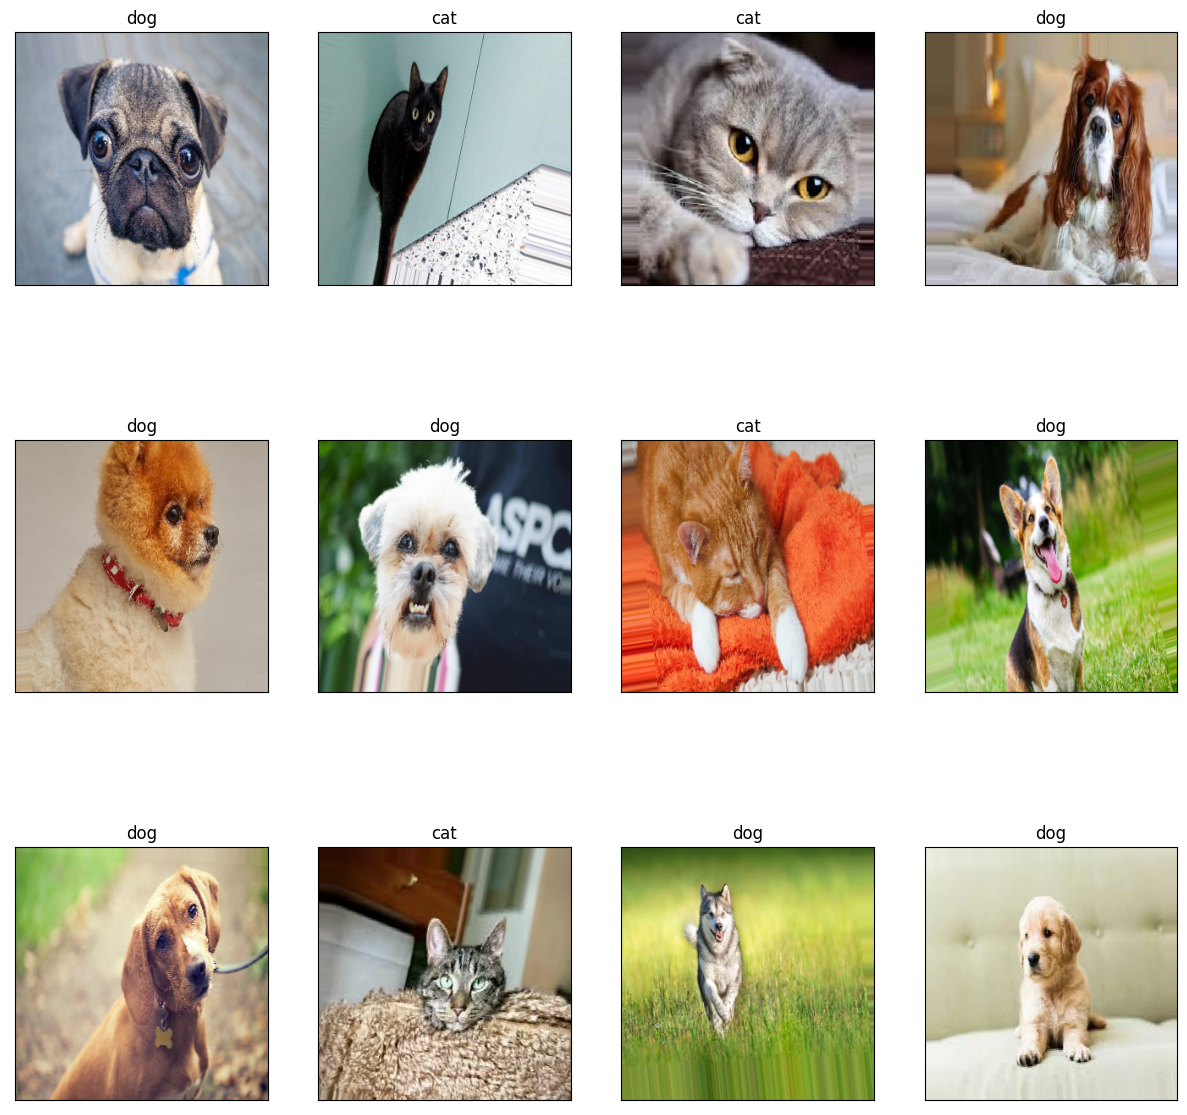

In [17]:
plt.figure(figsize=(15,15))
for i in range(12):
    ax = plt.subplot(3,4,i+1)
    ax.grid(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    batch = train_generator.next()
    imgs = (batch[0] + 1) * 127.5
    label = int(batch[1][0][0])
    image = imgs[0].astype('uint8')
    plt.imshow(image)
    plt.title('cat' if label==1 else 'dog')
plt.show()

In [18]:
train_generator.image_shape,validation_generator.image_shape,test_generator.image_shape

((299, 299, 3), (299, 299, 3), (299, 299, 3))

In [19]:

from sklearn.model_selection import train_test_split


from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

In [20]:
classifier=Sequential()
classifier.add(Conv2D(filters = 32, kernel_size = (7,7),
                activation = "relu", input_shape = (299,299,3)))
classifier.add(Conv2D(filters = 32, kernel_size = (7,7),
                activation = "relu"))
classifier.add(MaxPool2D(pool_size = (2,2)))
classifier.add(Dropout(0.5))

classifier.add(Conv2D(filters = 64, kernel_size = (5,5),
                activation = "relu"))
classifier.add(Conv2D(filters = 64, kernel_size = (5,5),
                activation = "relu"))
classifier.add(MaxPool2D(pool_size = (2,2), strides = (2,2)))
classifier.add(Dropout(0.5))

classifier.add(Conv2D(filters = 128, kernel_size = (3,3),
                activation = "relu"))
classifier.add(Conv2D(filters = 128, kernel_size = (3,3),
                activation = "relu"))
classifier.add(MaxPool2D(pool_size = (2,2), strides = (2,2)))
classifier.add(Dropout(0.5))

classifier.add(Flatten())
classifier.add(Dense(256, activation = "relu"))
classifier.add(Dropout(0.5))

classifier.add(Flatten())
classifier.add(Dense(128,activation='relu'))
classifier.add(Dense(64,activation='relu'))
classifier.add(Dense(2,activation='softmax',kernel_initializer='random_uniform'))

In [21]:
classifier.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 293, 293, 32)      4736      
                                                                 
 conv2d_10 (Conv2D)          (None, 287, 287, 32)      50208     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 143, 143, 32)     0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 143, 143, 32)      0         
                                                                 
 conv2d_11 (Conv2D)          (None, 139, 139, 64)      51264     
                                                                 
 conv2d_12 (Conv2D)          (None, 135, 135, 64)      102464    
                                                      

In [22]:
keras.utils.plot_model(
    classifier,
    show_shapes=True,
    show_dtype=True,
    show_layer_activations=True
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [25]:
classifier.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
save_checkpoint = keras.callbacks.ModelCheckpoint(filepath='model.h5', monitor='val_loss', save_best_only=True, verbose=1)

In [26]:
history1 = classifier.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // CFG['batch_size'],
        epochs=50,
        callbacks=[es,save_checkpoint],
        validation_data=validation_generator,
        verbose=True,
        validation_steps=nb_validation_samples // CFG['batch_size'])

Epoch 1/50
29/29 [==============================] - ETA: 0s - loss: 0.7026 - accuracy: 0.5129
Epoch 1: val_loss improved from inf to 0.69326, saving model to model.h5
29/29 [==============================] - 13s 263ms/step - loss: 0.7026 - accuracy: 0.5129 - val_loss: 0.6933 - val_accuracy: 0.4875
Epoch 2/50
29/29 [==============================] - ETA: 0s - loss: 0.6933 - accuracy: 0.4967
Epoch 2: val_loss did not improve from 0.69326
29/29 [==============================] - 8s 262ms/step - loss: 0.6933 - accuracy: 0.4967 - val_loss: 0.6934 - val_accuracy: 0.4875
Epoch 3/50
29/29 [==============================] - ETA: 0s - loss: 0.6933 - accuracy: 0.4946
Epoch 3: val_loss improved from 0.69326 to 0.69320, saving model to model.h5
29/29 [==============================] - 7s 236ms/step - loss: 0.6933 - accuracy: 0.4946 - val_loss: 0.6932 - val_accuracy: 0.4875
Epoch 4/50
29/29 [==============================] - ETA: 0s - loss: 0.6934 - accuracy: 0.4989
Epoch 4: val_loss did not improve

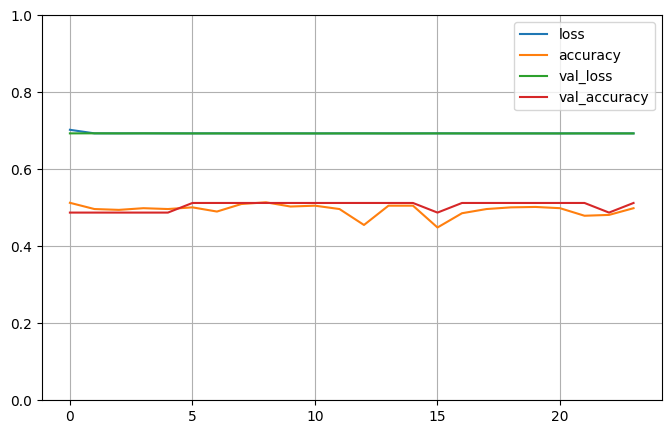

In [27]:
pd.DataFrame(history1.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

from google!

inception res net is a pretrained model which is pre trained for objects like pencils, cars, cats, dogs on more than a million images!

In [118]:
# Pre-trained deep convolutional neural network
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(CFG['img_size'][0], CFG['img_size'][1], 3))

# Add new layers
x = base_model.output
x = Flatten()(x)
x = Dense(100, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax', kernel_initializer='random_uniform')(x)

# Build model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Define optimiser
optimizer = Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [121]:
# Save the best model
save_checkpoint = keras.callbacks.ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

# Early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=CFG['patience'], verbose=True)

In [122]:
# Train model
history = model.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // CFG['batch_size'],
        epochs=25,
        callbacks=[early_stopping,save_checkpoint],
        validation_data=validation_generator,
        verbose=True,
        validation_steps=nb_validation_samples // CFG['batch_size'])

Epoch 1/25
29/29 [==============================] - ETA: 0s - loss: 0.0780 - accuracy: 0.9869
Epoch 1: val_loss improved from inf to 0.06352, saving model to best_model.h5
29/29 [==============================] - 8s 264ms/step - loss: 0.0780 - accuracy: 0.9869 - val_loss: 0.0635 - val_accuracy: 0.9875
Epoch 2/25
29/29 [==============================] - ETA: 0s - loss: 0.0349 - accuracy: 0.9869
Epoch 2: val_loss did not improve from 0.06352
29/29 [==============================] - 7s 238ms/step - loss: 0.0349 - accuracy: 0.9869 - val_loss: 0.1087 - val_accuracy: 0.9875
Epoch 3/25
29/29 [==============================] - ETA: 0s - loss: 0.0273 - accuracy: 0.9956
Epoch 3: val_loss did not improve from 0.06352
29/29 [==============================] - 7s 248ms/step - loss: 0.0273 - accuracy: 0.9956 - val_loss: 0.1129 - val_accuracy: 0.9875
Epoch 4/25
29/29 [==============================] - ETA: 0s - loss: 0.0031 - accuracy: 0.9978
Epoch 4: val_loss did not improve from 0.06352
29/29 [=====

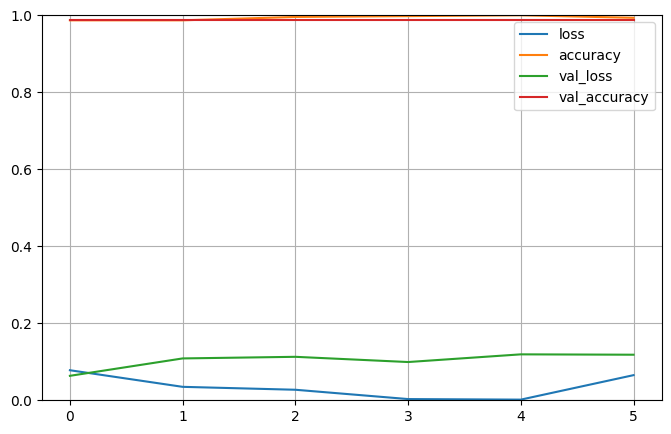

In [123]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [124]:
# Evaluate on validation dataset
score = model.evaluate(validation_generator, verbose=False)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.11547018587589264
Val accuracy: 0.9878048896789551


In [125]:
# Evaluate on test dataset
score = model.evaluate(test_generator, verbose=False)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.036144718527793884
Test accuracy: 0.9857142567634583


In [126]:
import seaborn as sns

9/9 [==============================] - 3s 118ms/step


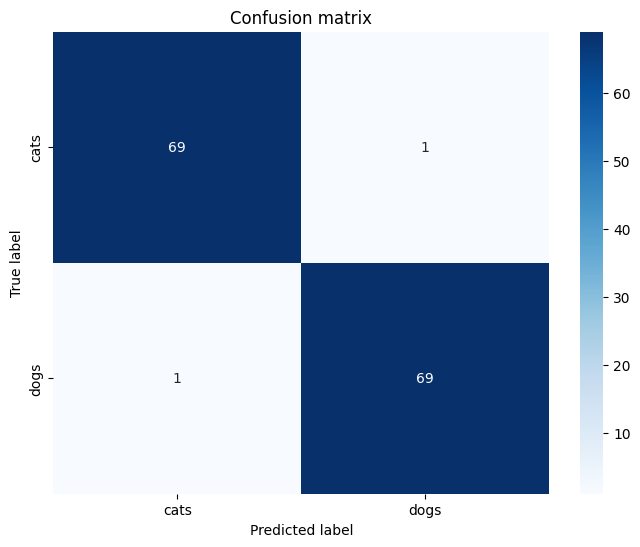

In [127]:
# Confusion matrix
y_pred = np.argmax(model.predict(test_generator), axis=1)
cm = confusion_matrix(test_generator.classes, y_pred)

# Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cbar=True, cmap='Blues',xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

Own model!

In [29]:
# Creating training set
training_set = train_data_generator.flow_from_directory(train_dir,
                                                 target_size = (299, 299),
                                                 shuffle=True,
                                                 batch_size = 16,
                                                 class_mode = 'binary',subset="training")
# Creating the Validation set
validation_set = val_data_generator.flow_from_directory(train_dir,
                                                 target_size = (299, 299),
                                                 shuffle=False,
                                                 batch_size = 16,
                                                 class_mode = 'binary',subset="validation")
# Creating the Test set
test_set = test_data_generator.flow_from_directory(test_dir,
                                            target_size = (299, 299),
                                            batch_size = 16,
                                            class_mode = 'binary')


Found 475 images belonging to 2 classes.
Found 82 images belonging to 2 classes.
Found 140 images belonging to 2 classes.


In [31]:
model = Sequential()
model.add(Conv2D(32,3,3,input_shape=(299,299,3),activation='relu'))
#step2-maxpooling
model.add(MaxPool2D(pool_size=(2,2)))
#step3-flattening
model.add(Flatten())
#step4-fullconnection
model.add(Dense(128,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [32]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 99, 99, 32)        896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 49, 49, 32)       0         
 2D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 76832)             0         
                                                                 
 dense_7 (Dense)             (None, 128)               9834624   
                                                                 
 dense_8 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9,835,649
Trainable params: 9,835,649
Non-trainable params: 0
____________________________________________

In [36]:
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
save_checkpoint = keras.callbacks.ModelCheckpoint(filepath='model_own.h5', monitor='val_loss', save_best_only=True, verbose=1)

In [37]:
hist=model.fit(training_set,steps_per_epoch=training_set.samples//16,epochs=50,
        callbacks=[save_checkpoint,es],validation_data=validation_set,verbose=True,validation_steps=validation_set.samples//16)

Epoch 1/50
29/29 [==============================] - ETA: 0s - loss: 0.5296 - accuracy: 0.7284
Epoch 1: val_loss improved from inf to 0.60383, saving model to model_own.h5
29/29 [==============================] - 7s 230ms/step - loss: 0.5296 - accuracy: 0.7284 - val_loss: 0.6038 - val_accuracy: 0.6875
Epoch 2/50
29/29 [==============================] - ETA: 0s - loss: 0.4682 - accuracy: 0.7734
Epoch 2: val_loss did not improve from 0.60383
29/29 [==============================] - 6s 222ms/step - loss: 0.4682 - accuracy: 0.7734 - val_loss: 0.6386 - val_accuracy: 0.6500
Epoch 3/50
29/29 [==============================] - ETA: 0s - loss: 0.4402 - accuracy: 0.7651
Epoch 3: val_loss did not improve from 0.60383
29/29 [==============================] - 6s 217ms/step - loss: 0.4402 - accuracy: 0.7651 - val_loss: 0.6439 - val_accuracy: 0.6750
Epoch 4/50
29/29 [==============================] - ETA: 0s - loss: 0.4738 - accuracy: 0.7586
Epoch 4: val_loss did not improve from 0.60383
29/29 [======

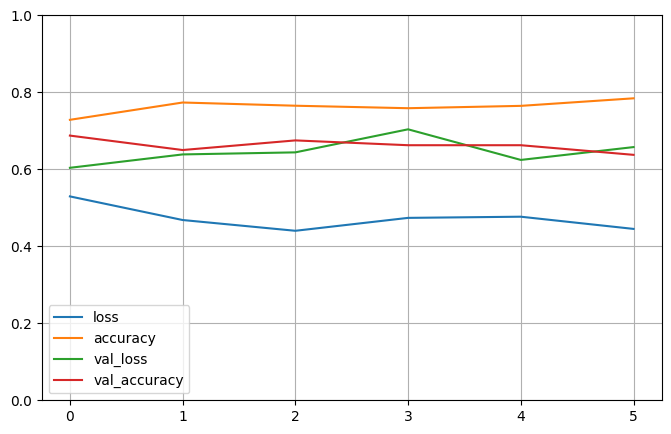

In [39]:
pd.DataFrame(hist.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()